In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2022-09-14 14:24:03.594983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-14 14:24:03.595010: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

In [3]:
n_slopes = 10
n_train = 10000
n_valid = 10000

slopes_lo = 0
slopes_hi = 5
data_lo = 0
data_hi = 1
n_dim = 2

In [4]:
slopes_train = np.random.uniform(
    low=slopes_lo, high=slopes_hi, size=n_slopes,
    )
slopes_valid = np.random.uniform(
    low=slopes_lo, high=slopes_hi, size=n_slopes,
    )

data_train = sample_powerlaw(
    (n_slopes, n_train, n_dim),
    slopes_train[:, None, None],
    data_lo,
    data_hi,
    )
data_valid = sample_powerlaw(
    (n_slopes, n_valid, n_dim),
    slopes_valid[:, None, None],
    data_lo,
    data_hi,
    )

slopes_train.shape, slopes_valid.shape, data_train.shape, data_valid.shape

((10,), (10,), (10, 10000, 2), (10, 10000, 2))

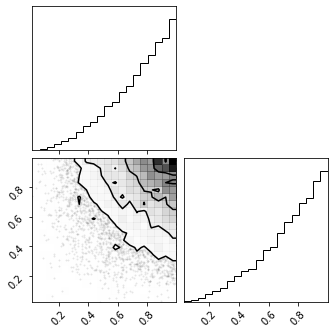

In [5]:
i = 0
corner(data_train[i]);

In [6]:
slopes_train = np.repeat(slopes_train[:, None, None], n_train, axis=1)
slopes_valid = np.repeat(slopes_valid[:, None, None], n_valid, axis=1)

slopes_train.shape, slopes_valid.shape

((10, 10000, 1), (10, 10000, 1))

In [7]:
slopes_train = slopes_train.reshape(-1, 1)
slopes_valid = slopes_valid.reshape(-1, 1)
data_train = data_train.reshape(-1, n_dim)
data_valid = data_valid.reshape(-1, n_dim)

slopes_train.shape, slopes_valid.shape, data_train.shape, data_valid.shape

((100000, 1), (100000, 1), (100000, 2), (100000, 2))

In [8]:
class Norm:
    
    def __init__(self, data):
        
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        
    def forward(self, x):
        
        return (x - self.mean) / self.std
    
    def inverse(self, y):
        
        return y * self.std + self.mean

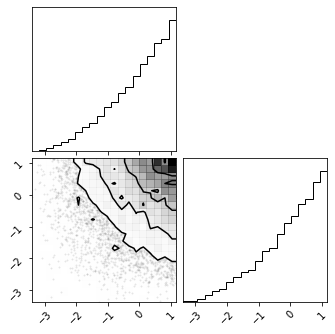

In [9]:
normalize = True

if normalize:
    
    slopes_norm = Norm(slopes_train)
    slopes_train = slopes_norm.forward(slopes_train)
    slopes_valid = slopes_norm.forward(slopes_valid)
    
    data_norm = Norm(data_train)
    data_train = data_norm.forward(data_train)
    data_valid = data_norm.forward(data_valid)
    
    i = 0
    corner(data_train[n_train*i:n_train*(i+1)]);

In [10]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

import re

def make_bijector_kwargs(bijector, name_to_kwargs):
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def make_kwargs(flow, condition):
    
    name_to_kwargs = {'maf.': {'conditional_input': condition}}
    
    return make_bijector_kwargs(flow.bijector, name_to_kwargs)

In [26]:
n_flows = 3
n_layers = 1
n_units = 128
activation = 'relu'

bijectors = []

# if normalize:
#     shift = -float(abs(data_norm.forward(data_lo)[0]))
#     scale = float(data_norm.forward(data_hi)[0] - data_norm.forward(data_lo)[0])
#     bijectors.append(tfb.Shift(shift=shift))
#     bijectors.append(tfb.Scale(scale=scale))
# bijectors.append(tfb.Scale(scale=.5))
# bijectors.append(tfb.Shift(shift=1.))
# bijectors.append(tfb.Tanh())

if normalize:
    shifts = data_norm.forward(data_lo).astype(np.float32)
    scales = (data_norm.forward(data_hi) - data_norm.forward(data_lo)).astype(np.float32)
    blockwise_bijectors = []
    for shift, scale in zip(shifts, scales):
        blockwise_bijectors.append(
            tfb.Chain([tfb.Shift(shift=shift), tfb.Scale(scale=scale)]),
            )
    blockwise_bijector = tfb.Blockwise(blockwise_bijectors, block_sizes=[1]*n_dim)
    bijectors.append(blockwise_bijector)

bijectors.append(tfb.Scale(scale=.5))
bijectors.append(tfb.Shift(shift=1.))
bijectors.append(tfb.Tanh())

for i in range(n_flows):
    
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=(n_dim,),
        conditional=True,
        conditional_event_shape=(1,),
        # conditional_input_layers='all_layers',
        hidden_units=[n_units]*n_layers,
        # input_order='left-to-right',
        # hidden_degrees='equal',
        activation=activation,
        use_bias=True,
        #kernel_initializer='zeros',
        kernel_initializer=tfk.initializers.RandomNormal(mean=0., stddev=.01),
        # kernel_initializer=tfk.initializers.Orthogonal(1e-2),
        bias_initializer='zeros',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6),
        # kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-2),
        # bias_regularizer=None,
        # kernel_constraint=None,
        # bias_constraint=None,
        # validate_args=False,
        # name=f'made{i}'
        )
    maf = tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
    bijectors.append(maf)
    
    # norm = tfb.BatchNormalization()
    # norm = tfb.Invert(tfb.BatchNormalization())
    # bijectors.append(norm)
    
    # if i < n_flows-1:
    permute = tfb.Permute(list(reversed(range(n_dim))))
    bijectors.append(permute)

bijector = tfb.Chain(bijectors)
distribution = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[n_dim])
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

x = tfk.Input(shape=(n_dim,), dtype=tf.float32)
c = tfk.Input(shape=(1,), dtype=tf.float32)

log_prob = nf.log_prob(
    x, bijector_kwargs=make_kwargs(nf, c),
    )

model = tfk.Model([x, c], log_prob)

In [27]:
epochs = 10
batch_size = 100
learning_rate = 1e-4

model.compile(
    # optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    optimizer=tfa.optimizers.AdamW(
        weight_decay=1e-6, learning_rate=learning_rate,
        ),
    loss=lambda _, log_prob: -log_prob,
    )

result = model.fit(
    x=[data_train, slopes_train],
    y=np.zeros(n_train*n_slopes, dtype=np.float32),
    validation_data=(
        [data_valid, slopes_valid],
        np.zeros(n_valid*n_slopes, dtype=np.float32),
        ),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    )

Epoch 1/10
1000/1000 [==============================] - 6s 5ms/step - loss: 2.3351 - val_loss: 2.3707
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.1058 - val_loss: 2.3531
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0836 - val_loss: 2.3340
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 2.0661 - val_loss: 2.3236
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0567 - val_loss: 2.3157
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0497 - val_loss: 2.3099
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0438 - val_loss: 2.3039
Epoch 8/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0388 - val_loss: 2.3003
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0352 - val_loss: 2.2977
Epoch 10/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.032

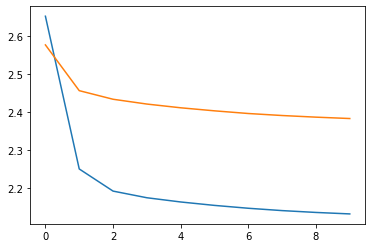

In [25]:
plt.plot(result.history['loss'][0:])
plt.plot(result.history['val_loss'][0:]);

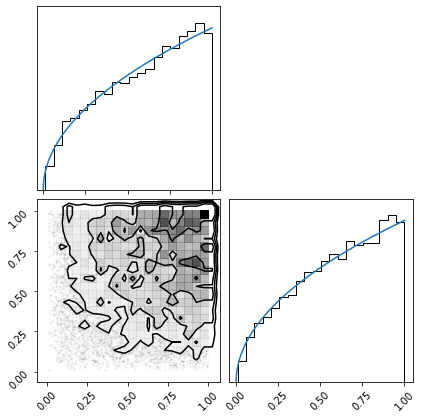

In [23]:
slope = 0.5
n = 10000

condition = slope * np.ones((n, 1))
if normalize:
    condition = slopes_norm.forward(condition)
bijector_kwargs = make_kwargs(nf, condition)

samples = nf.sample(n, bijector_kwargs=bijector_kwargs).numpy()
if normalize:
    samples = data_norm.inverse(samples)

fig, axs = plt.subplots(nrows=n_dim, ncols=n_dim, figsize=(7, 7))
corner(samples, fig=fig, hist_kwargs=dict(density=True))
x = np.linspace(data_lo, data_hi, 1000)
for i in range(n_dim):
    axs[i, i].plot(x, (slope+1)*x**slope)

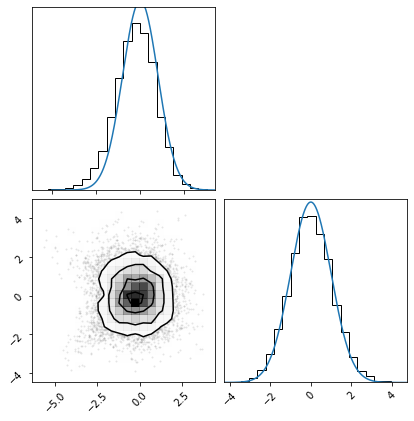

In [15]:
slope = 0
n = 10000

condition = slope * np.ones((n, 1))
if normalize:
    condition = slopes_norm.forward(condition)
bijector_kwargs = make_kwargs(nf, condition)

samples = sample_powerlaw([n, n_dim], slope, data_lo, data_hi).astype(np.float32)
if normalize:
    samples = data_norm.forward(samples)
samples = nf.bijector.inverse(samples, **bijector_kwargs).numpy()

fig, axs = plt.subplots(nrows=n_dim, ncols=n_dim, figsize=(7, 7))
corner(samples, fig=fig, hist_kwargs=dict(density=True))
x = np.linspace(-5, 5, 1000)
for i in range(n_dim):
    axs[i, i].plot(x, np.exp(-.5*x**2)/(2*np.pi)**.5)

In [67]:
from scipy.integrate import trapezoid

def cartesian_product(axes):

    return np.array(np.meshgrid(*axes, indexing='ij')).reshape(len(axes), -1)

def integrate_nd(y, x, dims=None):
    
    assert len(np.shape(y)) == len(x)
    n_dim = len(x)
    for dim in range(n_dim):
        assert np.shape(y)[dim] == len(x[dim])
        
    if dims is None:
        dims = np.arange(n_dim)
        
    for dim in np.flip(np.sort(dims)):
        y = trapezoid(y, x[dim], axis=dim)
        
    return y

def kl_trapezoid(p, q, x):
    
    return integrate_nd(p*(np.log(p)-np.log(q)), x)

def kl_montecarlo(p, q):
    
    return np.sum(np.log(p)-np.log(q)) / len(p)

In [130]:
slope = 0.
n = 100

condition = slope * np.ones((n**n_dim, 1))
bijector_kwargs = make_kwargs(nf, condition)

x = np.linspace(1e-3, 1-1e-3, n)
axes = [x, x]
grid = cartesian_product(axes)

p = np.product(powerlaw(grid, slope, lo, hi), axis=0).reshape(n, n)
q = nf.prob(grid.T, bijector_kwargs=bijector_kwargs).numpy().reshape(n, n)

kl_trapezoid(p, q, axes), kl_trapezoid(q, p, axes)

(0.003856967902496744, 0.0027362272463362586)

In [138]:
slope = 0.
n = 10000

condition = slope * np.ones((n, 1))
bijector_kwargs = make_kwargs(nf, condition)

samples = sample_powerlaw((n, n_dim), slope, lo, hi)
p = np.product(powerlaw(samples, slope, lo, hi), axis=1)
q = nf.prob(samples, bijector_kwargs=bijector_kwargs).numpy()

kl_montecarlo(p, q)

0.0037618948923685593

In [139]:
slope = 0.
n = 10000

condition = slope * np.ones((n, 1))
bijector_kwargs = make_kwargs(nf, condition)

samples = samples = nf.sample(n, bijector_kwargs=bijector_kwargs).numpy()
p = nf.prob(samples, bijector_kwargs=bijector_kwargs).numpy()
q = np.product(powerlaw(samples, slope, lo, hi), axis=1)

kl_montecarlo(p, q)

0.002556635284423828